# Recommender Systems

There is **no** relevant Chapter in Introduction to Statistical Learning (Gareth James et al.)

**Recommender Systems by Jannach and Zanker**


* Fully developed and deployed recommendation systesms are extremely complex and resource intensive
* Full recommender system requires a heavy linear algebra background
* 2 most common types of recommender systems are **Content-based** and **Collaborative Filtering (CF)**
    * **Collaborative Filtering** produces recommendations based on the knowledge of users' attitude to items, that is it uses the "wisdom of the crowd" to recommend items e.g. Amazon
    * **Content-based** recommender systems focus on the attributes of the items and give you recommendations base on the similarity between them
* In general, **CF** is more commonly used that **content-based** systems because it usually gives better results and is relatively easy to understand (from an overall implementaiton perspective)
* The algorithm has the ability to do feature learning on its own, which means that it can start to learn for itself what features to use
* **CF** can be devided into 2 sub categories
    * **Memory-based Collaborative Filtering**
    * **Model-based Collaborative Filtering**
        * in the advanced notebook tutorial we implement model-based CF by using singular value decomposition (SVD) and memory-based CF by computing cosine similarity (no accompanying video, just text)
* We'll be using the movielens dataset

___
# Recommender Systems with Python

Welcome to the code notebook for Recommender Systems with Python. In this lecture we will develop basic recommendation systems using Python and pandas. There is another notebook: *Advanced Recommender Systems with Python*. That notebook goes into more detail with the same data set.

In this notebook, we will focus on providing a basic recommendation system by suggesting items that are most similar to a particular item, in this case, movies. Keep in mind, this is not a true robust recommendation system, to describe it more accurately,it just tells you what movies/items are most similar to your movie choice.

There is no project for this topic, instead you have the option to work through the advanced lecture version of this notebook (totally optional!).

Let's get started!

## Import Libraries

In [2]:
import numpy as np
import pandas as pd

## Get the Data

In [9]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

In [10]:
df = pd.read_csv('u.data', sep='\t', names=column_names)

In [11]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


Now let's get the movie titles:

In [12]:
movie_titles = pd.read_csv('Movie_Id_Titles')

In [13]:
movie_titles.head()
# item_id and title

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


We can merge them together:

In [14]:
df = pd.merge(df, movie_titles, on='item_id')

In [15]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100003 entries, 0 to 100002
Data columns (total 5 columns):
user_id      100003 non-null int64
item_id      100003 non-null int64
rating       100003 non-null int64
timestamp    100003 non-null int64
title        100003 non-null object
dtypes: int64(4), object(1)
memory usage: 4.6+ MB


# EDA

Let's explore the data a bit and get a look at some of the best rated movies.

## Visualization Imports

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

Let's create a ratings dataframe with average rating and number of ratings:

In [21]:
df.groupby('title')['rating'].mean()
# mean rating for every title

title
'Til There Was You (1997)                2.333333
1-900 (1994)                             2.600000
101 Dalmatians (1996)                    2.908257
12 Angry Men (1957)                      4.344000
187 (1997)                               3.024390
                                           ...   
Young Guns II (1990)                     2.772727
Young Poisoner's Handbook, The (1995)    3.341463
Zeus and Roxanne (1997)                  2.166667
unknown                                  3.444444
Á köldum klaka (Cold Fever) (1994)       3.000000
Name: rating, Length: 1664, dtype: float64

In [22]:
df.groupby('title')['rating'].mean().sort_values(ascending=False)
# descending

title
Marlene Dietrich: Shadow and Light (1996)       5.0
Prefontaine (1997)                              5.0
Santa with Muscles (1996)                       5.0
Star Kid (1997)                                 5.0
Someone Else's America (1995)                   5.0
                                               ... 
Touki Bouki (Journey of the Hyena) (1973)       1.0
JLG/JLG - autoportrait de décembre (1994)       1.0
Daens (1992)                                    1.0
Butterfly Kiss (1995)                           1.0
Eye of Vichy, The (Oeil de Vichy, L') (1993)    1.0
Name: rating, Length: 1664, dtype: float64

In [23]:
# dataframe of mean ratings by title
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())

In [24]:
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


Now set the number of ratings column:

In [28]:
df.groupby('title')['rating'].count().sort_values(ascending=False)

title
Star Wars (1977)                              584
Contact (1997)                                509
Fargo (1996)                                  508
Return of the Jedi (1983)                     507
Liar Liar (1997)                              485
                                             ... 
Man from Down Under, The (1943)                 1
Marlene Dietrich: Shadow and Light (1996)       1
Mat' i syn (1997)                               1
Mille bolle blu (1993)                          1
Á köldum klaka (Cold Fever) (1994)              1
Name: rating, Length: 1664, dtype: int64

In [26]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())

In [27]:
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Now a few histograms:

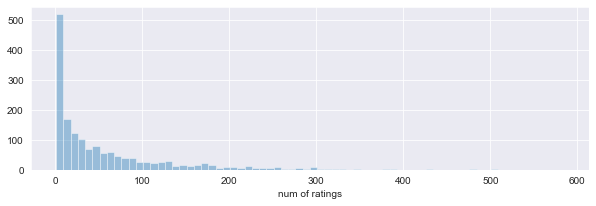

In [31]:
# Number of Ratings
# Seaborn
plt.figure(figsize=(10,3))
sns.distplot(ratings['num of ratings'], bins=70, kde=False)
# skewed distribution, many movies with 1 rating

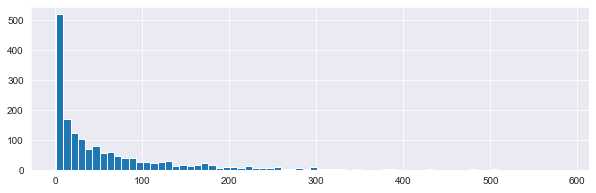

In [33]:
# Number of Ratings
# Plotly builtin
plt.figure(figsize=(10,3))
ratings['num of ratings'].hist(bins=70)

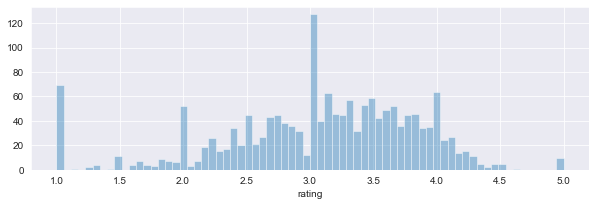

In [34]:
# Number of Ratings
# Seaborn
plt.figure(figsize=(10,3))
sns.distplot(ratings['rating'], bins=70, kde=False)
# peaks at whole numbers e.g. movies with 100 rating 3 starts averages to 3 stars

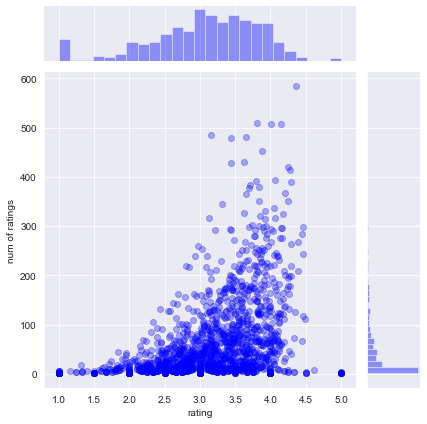

In [53]:
sns.jointplot('rating','num of ratings', ratings, color='blue', alpha=0.3)
# more ratings = more likely to have higher rating of a movie
# makes sense as popular movies are likely to be rated good
# better the movie, the more people will watch it, the more ratings it will get
# outlier at 5 stars, probably from 1 person watching and rating 5 stars

Okay! Now that we have a general idea of what the data looks like, let's move on to creating a simple recommendation system:

## Recommending Similar Movies

Now let's create a matrix that has the user ids on one access and the movie title on another axis. Each cell will then consist of the rating the user gave to that movie. Note there will be a lot of NaN values, because most people have not seen most of the movies.

In [54]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [55]:
moviemat = df.pivot_table(index='user_id', columns='title', values='rating')

In [56]:
moviemat.head()
# lots of missing values, which makes sense as most people haven't seen + rated all the movies

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most rated movie:

In [57]:
ratings.sort_values('num of ratings', ascending=False)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
...,...,...
"Great Day in Harlem, A (1994)",5.000000,1
"Other Voices, Other Rooms (1997)",3.000000,1
Good Morning (1971),1.000000,1


Let's choose two movies: starwars, a sci-fi movie. And Liar Liar, a comedy.

In [59]:
moviemat['Star Wars (1977)'].head()
# series of user ID with rating they gave it

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

In [60]:
moviemat['Liar Liar (1997)'].head()

user_id
0    NaN
1    NaN
2    1.0
3    2.0
4    5.0
Name: Liar Liar (1997), dtype: float64

Now let's grab the user ratings for those two movies:

In [62]:
starwars_user_ratings = moviemat['Star Wars (1977)']

In [63]:
liarliar_user_ratings = moviemat['Liar Liar (1997)']

We can then use corrwith() method to get correlations between two pandas series:

In [64]:
# corrwith() computes the pairwise corr between rows/ cols of 2 dataframes
moviemat.corrwith(starwars_user_ratings)
# returns titles of movies and their correlation with star wars user ratings

C:\Users\Sajakhta\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Sajakhta\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


title
'Til There Was You (1997)                0.872872
1-900 (1994)                            -0.645497
101 Dalmatians (1996)                    0.211132
12 Angry Men (1957)                      0.184289
187 (1997)                               0.027398
                                           ...   
Young Guns II (1990)                     0.228615
Young Poisoner's Handbook, The (1995)   -0.007374
Zeus and Roxanne (1997)                  0.818182
unknown                                  0.723123
Á köldum klaka (Cold Fever) (1994)            NaN
Length: 1664, dtype: float64

In [65]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)

In [67]:
similar_to_starwars.head()

title
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

In [66]:
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

In [68]:
similar_to_liarliar.head()

title
'Til There Was You (1997)    0.118913
1-900 (1994)                      NaN
101 Dalmatians (1996)        0.469765
12 Angry Men (1957)          0.066272
187 (1997)                   0.175145
dtype: float64

Let's clean this by removing NaN values and using a DataFrame instead of a series:

In [69]:
corr_starwars = pd.DataFrame(similar_to_starwars, columns=['Correlation'])
corr_starwars.dropna(inplace=True)

In [70]:
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


Now if we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that don't really make sense. This is because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie).

In [71]:
corr_starwars.sort_values('Correlation', ascending=False)

,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
...,...
For Ever Mozart (1996),-1.0
Frankie Starlight (1995),-1.0
I Like It Like That (1994),-1.0


Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).

In [72]:
corr_starwars = corr_starwars.join(ratings['num of ratings'])

In [73]:
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


Now sort the values and notice how the titles make a lot more sense:

In [90]:
# filter out movies with less than 100 ratings
# can play around with the filter value
corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation', ascending=False)
# impressive it picked other Star Wars movies and Harrison Ford movies

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
...,...,...
"Edge, The (1997)",-0.127167,113
As Good As It Gets (1997),-0.130466,112
Crash (1996),-0.148507,128


Now the same for the comedy Liar Liar:

In [77]:
# create liarliar dataframe for correlations and drop null values
corr_liarliar = pd.DataFrame(similar_to_liarliar, columns=['Correlation'])
corr_liarliar.dropna(inplace=True)

In [78]:
corr_liarliar.head()

,Correlation
title,
'Til There Was You (1997),0.118913
101 Dalmatians (1996),0.469765
12 Angry Men (1957),0.066272
187 (1997),0.175145
2 Days in the Valley (1996),0.040739


In [79]:
corr_liarliar.sort_values('Correlation', ascending=False)
# highly corr movies seem irrelevant becuase they're movies that have maybe a 1 or a few reviews

,Correlation
title,
"Bonheur, Le (1965)",1.0
For Ever Mozart (1996),1.0
Crossfire (1947),1.0
Johnny 100 Pesos (1993),1.0
Moonlight and Valentino (1995),1.0
...,...
Aparajito (1956),-1.0
"Quiet Room, The (1996)",-1.0
Germinal (1993),-1.0


In [80]:
# join the number of ratings on to the liarlilar corr dataframe
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])

In [81]:
corr_liarliar.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.118913,9
101 Dalmatians (1996),0.469765,109
12 Angry Men (1957),0.066272,125
187 (1997),0.175145,41
2 Days in the Valley (1996),0.040739,93


In [85]:
# filter out movies with less than 100 ratings
# can play around with the filter value
corr_liarliar[corr_liarliar['num of ratings']>100].sort_values('Correlation', ascending=False)
# impressive, it picked 2 other  Jim Carey movies in top 5

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
...,...,...
Hoop Dreams (1994),-0.184503,117
Ed Wood (1994),-0.199481,133
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963),-0.238092,194
